# Housing Price Prediction

In this project, we will focus on a regression task where our main goal is to predict the sale price of houses. We'll do this by examining various characteristics of each house. It's important to remember that the quality of our predictions depends heavily on the quality of our data. Therefore, we'll take a detailed look at the features in our dataset to ensure they're suitable for our analysis.

### Data Splitting 

In [1]:
import numpy as np
import pandas as pd
import altair as alt 

In [2]:
trainset = pd.read_csv("data/train.csv")
testset = pd.read_csv("data/test.csv")
samplesubmission = pd.read_csv("data/sample_submission.csv")

In [3]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
train_df, test_df= train_test_split(trainset, test_size = 0.3, random_state=123)

In [4]:
X_train = train_df.drop(columns = ["SalePrice"])
y_train = train_df["SalePrice"]
X_train = test_df.drop(columns = ["SalePrice"])
y_train = test_df["SalePrice"]

### EDA

### Feature dropping

From the provided list, the columns `Alley`, `PoolQC`, `Fence`, and `MiscFeature` each have fewer than 100 entries. This limited data might not offer sufficient information for reliable analysis. To maintain model simplicity and effectiveness, we have decided to drop these features.

In [5]:
X_train = X_train.drop(columns = ["Alley", "PoolQC", "Fence", "MiscFeature"])

In [6]:
X_train_copy = X_train.copy(deep=True)

### Data Imputing

In [7]:
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 147 to 554
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             438 non-null    int64  
 1   MSSubClass     438 non-null    int64  
 2   MSZoning       438 non-null    object 
 3   LotFrontage    342 non-null    float64
 4   LotArea        438 non-null    int64  
 5   Street         438 non-null    object 
 6   LotShape       438 non-null    object 
 7   LandContour    438 non-null    object 
 8   Utilities      438 non-null    object 
 9   LotConfig      438 non-null    object 
 10  LandSlope      438 non-null    object 
 11  Neighborhood   438 non-null    object 
 12  Condition1     438 non-null    object 
 13  Condition2     438 non-null    object 
 14  BldgType       438 non-null    object 
 15  HouseStyle     438 non-null    object 
 16  OverallQual    438 non-null    int64  
 17  OverallCond    438 non-null    int64  
 18  YearBuilt    

In [8]:
len(X_train_copy.columns[X_train_copy.isna().any()].tolist())

14

In [9]:
X_train_copy.columns[X_train_copy.isna().any()].tolist()

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

After looking at the data, we found that among these 75 features, there are 14 features that have missing values. To impute the values, we need to take a closer look at these features and what they represent. 

#### LotFrontage

`LotFrontage` is defined as the linear feet of street connected to the property. Upon examination, we find that this column contains 342 entries, as opposed to the expected 438, indicating the presence of approximately 100 missing values. Given the significance of LotFrontage in property assessment, it would be more advisable to impute these missing values rather than to eliminate the column entirely. This approach ensures that we retain the integral information that LotFrontage provides for our analysis. 

In [10]:
import altair as alt 
alt.Chart(X_train_copy).mark_bar().encode(
    x = alt.X("LotFrontage", bin = alt.Bin(maxbins=40)) ,
    y = "count()"
)

alt.Chart(...)

As we can see from the distribution graph above, this numeric data is right skewed mostly because there are few outliers existing in the dataset. Upon closer examination, there are only 4 entries that contain larger than 130 `LotFrontage`. We decide to drop these entries and impute the rest with median. 

In [11]:
X_train_copy[X_train_copy["LotFrontage"]>130]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1127,1128,20,RL,182.0,14572,Pave,IR3,Lvl,AllPub,Corner,...,36,0,0,0,0,0,11,2007,WD,Family
171,172,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,...,62,0,0,0,0,0,5,2010,WD,Normal
1337,1338,30,RM,153.0,4118,Pave,IR1,Bnk,AllPub,Corner,...,20,0,0,0,0,0,3,2006,WD,Normal
934,935,20,RL,313.0,27650,Pave,IR2,HLS,AllPub,Inside,...,0,0,0,0,0,0,11,2008,WD,Normal


In [12]:
X_train_copy = X_train_copy.drop(index = [1127, 171, 1337, 934])

In [13]:
X_train_copy["LotFrontage" + '_missing'] = X_train_copy["LotFrontage"].isnull().astype(int)

In [14]:
import altair as alt 
alt.Chart(X_train_copy).mark_bar().encode(
    x = alt.X("LotFrontage", bin = alt.Bin(maxbins=40)) ,
    y = "count()"
)

alt.Chart(...)

#### MasVnrType

`MasVnrType` represents Masonry veneer type, which is a categorical feature. 

In [15]:
X_train_copy["MasVnrType"].value_counts()

MasVnrType
BrkFace    131
Stone       48
BrkCmn       4
Name: count, dtype: int64

Upon detailed analysis, it's observed that `BrkFace` is the most common category in the `MasVnrType` column. Yet, encoding all missing values as `BrkFace` would lead to an imbalance, as the 254 values to be imputed would exceed the existing data count in this category. To avoid skewing the data, we have opted to label these missing entries as `Unknown`. This approach not only preserves the integrity of the data but also maintains the distinction of the missing values.

#### MasVnrArea 

`MasVnrArea` is a numerical feature representing Masonry veneer area in square feet. 

In [16]:
alt.Chart(X_train_copy).mark_bar().encode(
    x = alt.X("MasVnrArea", bin = alt.Bin(maxbins=30)) ,
    y = "count()"
)

alt.Chart(...)

After plotting, we can see that our data is heavily right-skewed. We need to take a closer look at the most frequent value of this feature.

In [17]:
X_train_copy["MasVnrArea"].value_counts()

MasVnrArea
0.0      245
106.0      4
180.0      3
16.0       3
76.0       2
        ... 
116.0      1
75.0       1
218.0      1
150.0      1
292.0      1
Name: count, Length: 158, dtype: int64

In [18]:
len(X_train_copy[X_train_copy["MasVnrArea"] != 0]["MasVnrArea"])

189

Most of the values for this feature is 0.0, which could mean that most of the house does not have Masonry veneer area. To avoid skewedness of the data, we chose median to impute the value. Later, we should look at whether this feature is important or not. If not, we should consider dropping this feature all together. 

In [19]:
alt.Chart(X_train_copy[X_train_copy["MasVnrArea"] != 0]).mark_bar().encode(
    x = alt.X("MasVnrArea", bin = alt.Bin(maxbins=30)) ,
    y = "count()"
)

alt.Chart(...)

In [20]:
median = X_train_copy[X_train_copy["MasVnrArea"] != 0]["MasVnrArea"].median()

median

In [21]:
X_train_copy["MasVnrArea" + '_missing'] = (X_train_copy["MasVnrArea"]==0).astype(int)

#### BsmtQual

`BsmtQual` denotes the height of the basement. It's possible that missing values in this field indicate that the house lacks a basement altogether.

In [22]:
X_train_copy["BsmtQual"].value_counts()

BsmtQual
Gd    196
TA    190
Ex     33
Fa      5
Name: count, dtype: int64

In [23]:
len(X_train_copy["BsmtQual"])

434

As we can see that there are 4 missing values for this feature, we can simply input the missing value using the most frequent type `Gd`. However, since the categories of `Ex` and `Fa` is too little, we decide to group them into 1 category. 

In [24]:
X_train_copy.loc[(X_train_copy["BsmtQual"] == "Ex") | (X_train_copy["BsmtQual"] == "Fa"), "BsmtQual"] = "other"

In [25]:
X_train["BsmtQual"].value_counts()

BsmtQual
Gd    198
TA    192
Ex     33
Fa      5
Name: count, dtype: int64

#### BsmtCond

`BsmtCond` denotes the General condition of the basement. It's possible that missing values in this field indicate that the house lacks a basement altogether.

In [26]:
X_train_copy["BsmtCond"].value_counts()

BsmtCond
TA    392
Gd     20
Fa     12
Name: count, dtype: int64

In [27]:
len(X_train_copy["BsmtCond"])

434

As we can see that there are 4 missing values for this feature, we can simply input the missing value using the most frequent type `TA`. 

In [28]:
X_train_copy.loc[(X_train_copy["BsmtCond"] == "Gd") | (X_train_copy["BsmtCond"] == "Fa"), "BsmtCond"] = "other"

In [29]:
X_train_copy["BsmtCond"].value_counts()

BsmtCond
TA       392
other     32
Name: count, dtype: int64

#### BsmtExposure

Same as the previous 2 feautures, we will impute the missing value using the most frequent type `No`. 

In [30]:
X_train_copy["BsmtExposure"].value_counts()

BsmtExposure
No    270
Av     74
Gd     43
Mn     37
Name: count, dtype: int64

In [31]:
len(X_train_copy["BsmtExposure"])

434

In [32]:
X_train_copy.loc[(X_train_copy["BsmtExposure"] == "Av") | (X_train_copy["BsmtExposure"] == "Gd") | (X_train_copy["BsmtExposure"] == "Mn"), "BsmtExposure"] = "other"

In [33]:
X_train_copy["BsmtExposure"].value_counts()

BsmtExposure
No       270
other    154
Name: count, dtype: int64

#### BsmtFinType1

In [34]:
X_train_copy["BsmtFinType1"].value_counts()

BsmtFinType1
GLQ    128
Unf    125
ALQ     64
Rec     46
BLQ     42
LwQ     19
Name: count, dtype: int64

In [35]:
len(X_train_copy["BsmtFinType1"])

434

#### BsmtFinType2


In [36]:
X_train_copy["BsmtFinType2"].value_counts()

BsmtFinType2
Unf    369
LwQ     20
BLQ     12
Rec     12
ALQ      6
GLQ      4
Name: count, dtype: int64

In [37]:
len(X_train_copy["BsmtFinType2"])

434

In [38]:
X_train_copy.loc[
    (X_train_copy["BsmtFinType2"] == "LwQ") | 
    (X_train_copy["BsmtFinType2"] == "BLQ") | 
    (X_train_copy["BsmtFinType2"] == "Rec") | 
    (X_train_copy["BsmtFinType2"] == "ALQ") | 
    (X_train_copy["BsmtFinType2"] == "GLQ"), 
    "BsmtFinType2"
] = "other"

In [39]:
X_train_copy["BsmtFinType2"].value_counts()

BsmtFinType2
Unf      369
other     54
Name: count, dtype: int64

#### FireplaceQu


`FireplaceQu` represents the Fireplace quality. 

In [40]:
X_train_copy["FireplaceQu"].value_counts()

FireplaceQu
TA    104
Gd    103
Po      9
Fa      7
Ex      6
Name: count, dtype: int64

In [41]:
len(X_train_copy["FireplaceQu"])

434

In [42]:
X_train_copy.loc[
    (X_train_copy["FireplaceQu"] == "Po") | 
    (X_train_copy["FireplaceQu"] == "Fa") | 
    (X_train_copy["FireplaceQu"] == "Ex"), 
    "FireplaceQu"
] = "other"

In [43]:
X_train_copy["FireplaceQu"].value_counts()

FireplaceQu
TA       104
Gd       103
other     22
Name: count, dtype: int64

#### GarageType

In [44]:
X_train_copy["GarageType"].value_counts()

GarageType
Attchd     267
Detchd     107
BuiltIn     32
Basment      5
2Types       3
CarPort      1
Name: count, dtype: int64

In [45]:
len(X_train_copy["GarageType"])

434

In [47]:
X_train_copy.loc[
    (X_train_copy["GarageType"] == "Basment") | 
    (X_train_copy["GarageType"] == "2Types") | 
    (X_train_copy["GarageType"] == "BuiltIn") |
    (X_train_copy["GarageType"] == "CarPort"), 
    "GarageType"
] = "other"

In [48]:
X_train_copy["GarageType"].value_counts()

GarageType
Attchd    267
Detchd    107
other      41
Name: count, dtype: int64

#### GarageYrBlt


This column indicates the year the garage is built. Since there are only 4 missing values, we can simply impute using the median value. 

In [49]:
X_train_copy["GarageYrBlt"].value_counts()

GarageYrBlt
2005.0    28
2003.0    18
2006.0    16
2004.0    14
2007.0    13
          ..
1936.0     1
1932.0     1
1988.0     1
1939.0     1
1985.0     1
Name: count, Length: 81, dtype: int64

In [50]:
alt.Chart(X_train_copy).mark_bar().encode(
    x = "GarageYrBlt",
    y = "count()"
)

alt.Chart(...)

In [51]:
len(X_train_copy["GarageYrBlt"])

434

#### GarageFinish


In [52]:
X_train_copy["GarageFinish"].value_counts()

GarageFinish
Unf    173
RFn    139
Fin    103
Name: count, dtype: int64

In [53]:
len(X_train_copy["GarageFinish"])

434

#### GarageQual

In [54]:
X_train_copy["GarageQual"].value_counts()

GarageQual
TA    400
Fa     10
Ex      2
Gd      2
Po      1
Name: count, dtype: int64

In [55]:
len(X_train_copy["GarageQual"])

434

In [56]:
X_train_copy.loc[
    (X_train_copy["GarageQual"] == "Fa") | 
    (X_train_copy["GarageQual"] == "Ex") | 
    (X_train_copy["GarageQual"] == "Gd") |
    (X_train_copy["GarageQual"] == "Po"), 
    "GarageQual"
] = "other"

In [57]:
X_train_copy["GarageQual"].value_counts()

GarageQual
TA       400
other     15
Name: count, dtype: int64

#### GarageCond

In [58]:
X_train_copy["GarageCond"].value_counts()

GarageCond
TA    399
Fa     10
Po      3
Gd      2
Ex      1
Name: count, dtype: int64

In [59]:
len(X_train_copy["GarageCond"])

434

In [60]:
X_train_copy.loc[
    (X_train_copy["GarageCond"] == "Fa") | 
    (X_train_copy["GarageCond"] == "Ex") | 
    (X_train_copy["GarageCond"] == "Gd") |
    (X_train_copy["GarageCond"] == "Po"), 
    "GarageCond"
] = "other"

In [61]:
X_train_copy["GarageCond"].value_counts()

GarageCond
TA       399
other     16
Name: count, dtype: int64

To conclude,  <br>
`LotFrontage`: numerical, impute median, remove entries >130, scaler, add a column for missing value indicator <br>
`MasVnrType`: categorical, impute unknown, feature regrouping  <br>
`MasVnrArea`: numerical, impute median, add a column for missing value indicator <br>
`BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `FireplaceQu`, `GarageType`, `GarageFinish`, `GarageQual`,
`GarageCond`: <br> categorical, impute most frequent value, feature regrouping <br>
`GarageYrBlt`: numerical, impute median(only 4 missing), scaler <br>
`Alley`, `PoolQC`, `Fence`, `MiscFeature`: drop

### Examining Distribution of the features

In [62]:
from sklearn.impute import SimpleImputer

In [63]:
# Imputer for numerical columns
numerical_imputer = SimpleImputer(strategy='median')

# Imputer for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer_unknown = SimpleImputer(strategy='constant', fill_value = "unknown")

In [73]:
numeric_feat = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
cat_feat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
          'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
         'GarageQual', 'GarageCond']
cat_feat_missing = ['MasVnrType']
passthrough = [

In [77]:
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 147 to 554
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   434 non-null    int64  
 1   MSSubClass           434 non-null    int64  
 2   MSZoning             434 non-null    object 
 3   LotFrontage          338 non-null    float64
 4   LotArea              434 non-null    int64  
 5   Street               434 non-null    object 
 6   LotShape             434 non-null    object 
 7   LandContour          434 non-null    object 
 8   Utilities            434 non-null    object 
 9   LotConfig            434 non-null    object 
 10  LandSlope            434 non-null    object 
 11  Neighborhood         434 non-null    object 
 12  Condition1           434 non-null    object 
 13  Condition2           434 non-null    object 
 14  BldgType             434 non-null    object 
 15  HouseStyle           434 non-null    object

In [74]:
from sklearn.compose import ColumnTransformer
import warnings

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.utils.validation')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_imputer, numeric_feat),
        ("cat", categorical_imputer, 
         cat_feat),
        ("cat_missing", categorical_imputer_unknown, cat_feat_missing)
    ])

In [75]:
X_train__copy_transformed = preprocessor.fit_transform(X_train_copy)

In [76]:
X_train_copy_transformed_df = pd.DataFrame(
    X_train__copy_transformed, 
    columns=numeric_feat + cat_feat + cat_feat_missing,  # Update column names as appropriate
    index=X_train_copy.index
)
X_train_copy_transformed_df

,LotFrontage,GarageYrBlt,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,MasVnrType
147,70.0,2001.0,180.0,Gd,TA,No,Unf,Unf,Gd,other,Fin,TA,TA,BrkFace
676,60.0,1920.0,0.0,TA,other,No,Unf,Unf,TA,other,Unf,other,other,unknown
1304,32.0,2004.0,117.0,Gd,TA,No,Unf,Unf,TA,Detchd,Unf,TA,TA,Stone
1372,75.0,1998.0,0.0,Gd,TA,other,GLQ,Unf,TA,Detchd,RFn,TA,TA,unknown
1427,60.0,1962.0,0.0,TA,TA,No,BLQ,Unf,TA,Attchd,Unf,TA,TA,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,70.0,1983.0,0.0,Gd,TA,other,BLQ,other,TA,Attchd,Unf,TA,TA,unknown
1096,60.0,1981.0,0.0,TA,TA,No,Unf,Unf,TA,Attchd,Unf,TA,TA,unknown
637,50.0,1954.0,0.0,TA,TA,No,Unf,Unf,TA,other,Unf,TA,TA,unknown
753,80.0,2005.0,178.0,Gd,TA,other,Unf,Unf,Gd,Attchd,RFn,TA,TA,BrkFace


log transformation

In [ ]:
imp_attributes = ['OverallQual', 'YearBuilt','YearRemodAdd', 'MasVnrArea','TotalBsmtSF','1stFlrSF',
                  'GrLivArea', 'FullBath','TotRmsAbvGrd','Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea']
rest_attributes = [col for col in X.columns if col not in selected_features]
train_X_imp = train_X[imp_attributes]
val_X_imp = val_X[imp_attributes]

In [ ]:
# Apply log transformation to the data
log_train_X_imp = np.log(train_X_imp)

log_y_train = np.log(y_train)

Clean Outliers

In [ ]:
q_low = log_train_X_imp["col"].quantile(0.25)
q_hi  = log_train_X_imp["col"].quantile(0.75)

train_x_filtered = df[(log_train_X_imp["col"] < q_hi) & (log_train_X_imp["col"] > q_low)]

find distribution of X relative to Y

In [ ]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features = list(train_x_filtered.columns)
spearman(train_x_filtered, features)

Clearing missing values of numerical features

In [ ]:
from sklearn.impute import SimpleImputer
def missing_numerical(X_train):
    imputer = SimpleImputer(strategy="median") #a. creating imputer instance

    X_num = X_train.select_dtypes(include=['int64','float64']) #choosing num attributes
    imputer.fit(X_num) #b. fitting
    # It computed the mean of each attribute and stored the result in statistics_ instance variable

    X = imputer.transform(X_num) #c. transformed the data as per requirement and generated a plain np array
    train_X = pd.DataFrame(X, columns=X_num.columns)
    return train_X
train_X = missing_numerical(X_train)
val_X = missing_numerical(X_val)

In [ ]:
train_X

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1450.0,180.0,21.0,1533.0,5.0,7.0,1970.0,1970.0,0.0,553.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2006.0
1,539.0,20.0,70.0,11553.0,5.0,5.0,1968.0,1968.0,188.0,673.0,...,336.0,466.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2006.0
2,1209.0,20.0,70.0,7763.0,5.0,7.0,1962.0,1980.0,0.0,504.0,...,506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2008.0
3,817.0,20.0,70.0,11425.0,5.0,6.0,1954.0,1954.0,0.0,486.0,...,275.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0,7.0,2006.0
4,165.0,40.0,40.0,5400.0,6.0,7.0,1926.0,2004.0,0.0,370.0,...,216.0,0.0,0.0,183.0,0.0,0.0,0.0,0.0,10.0,2007.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,775.0,20.0,110.0,14226.0,8.0,5.0,2006.0,2006.0,375.0,0.0,...,895.0,315.0,45.0,0.0,0.0,0.0,0.0,0.0,7.0,2007.0
1164,491.0,160.0,70.0,2665.0,5.0,6.0,1976.0,1976.0,0.0,0.0,...,336.0,141.0,24.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0
1165,50.0,20.0,66.0,7742.0,5.0,7.0,1966.0,1966.0,0.0,763.0,...,386.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2007.0
1166,1260.0,20.0,65.0,9750.0,6.0,8.0,1969.0,1969.0,0.0,602.0,...,460.0,180.0,0.0,0.0,0.0,80.0,0.0,0.0,7.0,2008.0


4.model selection


In [ ]:
dict_mse={} #creating Mean Squared Error Dictionary

In [ ]:
from sklearn.metrics import mean_squared_error

def model_application(model, model_name, train_X, y_train, val_X, y_val):
    model.fit(train_X, y_train)

    predictions = model.predict(val_X)

    mse = mean_squared_error(y_val, predictions)
    dict_mse[model_name] = np.sqrt(mse) #root_mean_squared_error
    dict_mse[model_name]
    return model  #returning trained model

In [ ]:
dict_mse={} #creating Mean Squared Error Dictionary


In [ ]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model = model_application(lr_model, 'Linear Regression', train_X_imp, y_train, val_X_imp, y_val)
lr_model_imp = LinearRegression()
lr_model = model_application(lr_model_imp, 'Linear Regression for important attributes', train_X, y_train, val_X, y_val)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg = model_application(forest_reg, 'Random Forest Regressor', train_X, y_train, val_X, y_val)
forest_reg_imp = RandomForestRegressor()
forest_reg_imp = model_application(forest_reg_imp, 'Random Forest Regressor for important attributes', train_X_imp, y_train, val_X_imp, y_val)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg = model_application(tree_reg, 'Decision Tree Regressor for important attributes', train_X_imp, y_train, val_X_imp, y_val)
tree_reg_imp = DecisionTreeRegressor()
tree_reg = model_application(tree_reg_imp, 'Decision Tree Regressor', train_X, y_train, val_X, y_val)

In [ ]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg = model_application(xgb_reg, 'XGBoost Regressor', train_X, y_train, val_X, y_val)
xgb_reg_imp = XGBRegressor()
xgb_reg_imp = model_application(xgb_reg_imp, 'XGBoost Regressor for important attributes', train_X_imp, y_train, val_X_imp, y_val)

In [ ]:
dict_mse

{'Linear Regression': 48787.381235482484,
 'Linear Regression for important attributes': 50624.98829019631,
 'Random Forest Regressor': 32276.61373724122,
 'Random Forest Regressor for important attributes': 33982.4135846535,
 'Decision Tree Regressor for important attributes': 42976.39244439029,
 'Decision Tree Regressor': 36513.67781651632,
 'XGBoost Regressor': 31337.718886309416,
 'XGBoost Regressor for important attributes': 29152.37031288916}

4.train/tune with various model

In [ ]:
test_X = missing_numerical(testset) #dealing with numerical missing values
test_X_imp = test_X[imp_attributes]

my_result = forest_reg.predict(test_X) #predicting


In [ ]:
# Saving the result into submission file
submission = pd.read_csv("/content/drive/My Drive/kaggle project/house-prices-advanced-regression-techniques/sample_submission.csv")
submission["SalePrice"] = my_result
submission.to_csv('submission.csv', index=False)  #Competition rules require that no index number be savedmodel.fit()


In [ ]:
samplesubmission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


5.feature selection

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def find_optimal_num_components(train_X, max_components=None, plot=True):
    # Standardize the data
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)

    # Apply PCA
    pca = PCA()
    pca.fit(train_X_scaled)

    # Calculate cumulative explained variance ratio
    explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

    # Plot explained variance ratio curve
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o')
        plt.title('Explained Variance Ratio Cumulative Sum')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.grid(True)
        plt.show()

    # Find the optimal number of components
    if max_components is None:
        optimal_num_components = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1
    else:
        optimal_num_components = max_components

    return optimal_num_components


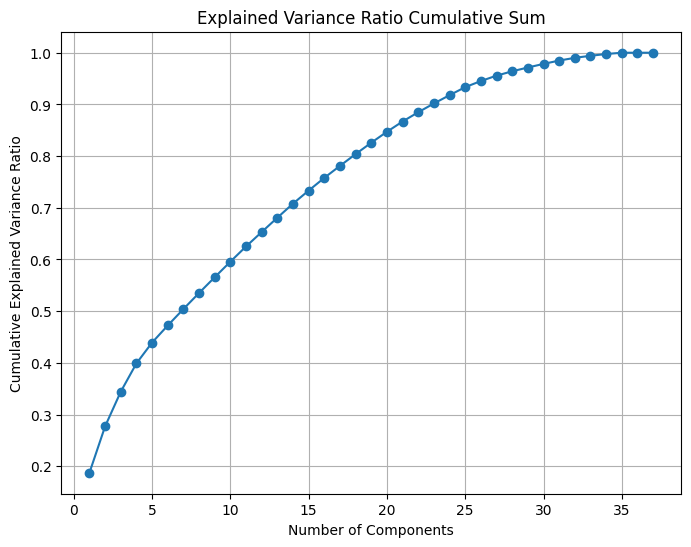

Optimal number of components: 27


In [ ]:
# Assuming X_train is your training dataset
optimal_components = find_optimal_num_components(train_X)
print("Optimal number of components:", optimal_components)

6.test and see differences

In [ ]:

# Assuming X_train and X_val are your train and validation datasets
# Standardize the data
s = StandardScaler()
train_X_scaled = s.fit_transform(train_X)
val_X_scaled = s.transform(val_X)

# Apply PCA
num_components = 27  # Choose the number of principal components
pca = PCA(n_components=num_components)
train_X_pca = pca.fit_transform(train_X_scaled)
val_X_pca = pca.transform(val_X_scaled)


In [ ]:
pca

PCA(n_components=27)

In [ ]:
train_X_pca


array([[-5.06825495, -1.59485037, -2.35738872, ...,  0.11312194,
         0.90982127,  0.03841437],
       [-0.68025625, -0.45744824,  0.71039962, ..., -1.10070178,
        -0.76314185,  0.17819333],
       [-1.29246603, -1.30424527,  0.69265009, ...,  0.83067303,
        -0.14178123, -0.46855546],
       ...,
       [-2.57159973, -1.27485408,  0.73357365, ...,  0.73309673,
         0.03512506, -0.24056149],
       [-1.21916364, -1.27002836,  1.02174798, ...,  0.33666471,
        -0.14193615,  0.08121947],
       [ 1.4856287 , -2.18086878,  0.99180656, ..., -0.37193021,
        -1.25154593, -0.66416988]])

In [ ]:
val_X_pca

array([[ 0.10641499, -2.23562593, -0.67283949, ...,  0.81503155,
        -0.49997102, -0.74501102],
       [-1.15328766, -3.28788517, -2.37067192, ..., -1.36412214,
         0.32645127, -0.68818454],
       [-0.82303142, -1.11998786,  0.25529503, ...,  0.53643433,
        -0.2170584 , -0.28732892],
       ...,
       [-2.49406899, -0.96087635, -0.14464881, ...,  0.38803057,
        -0.42042983, -0.03387971],
       [ 0.62987947, -1.1326779 , -1.99617004, ..., -0.14784418,
        -0.93262502,  0.24047372],
       [-3.65437565,  0.9957098 ,  0.98586187, ...,  0.13072033,
         0.32730738,  0.49465723]])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg = model_application(forest_reg, 'Random Forest Regressor', train_X, y_train, val_X, y_val)
forest_reg_pca = RandomForestRegressor()
forest_reg_pca = model_application(forest_reg_pca, 'Random Forest Regressor for pca attributes', train_X_pca, y_train, val_X_pca, y_val)

In [ ]:
pca_result = forest_reg_pca.predict(val_X_pca) #predicting

In [ ]:
my_result = forest_reg.predict(val_X)

In [ ]:
len(pca_result)

292

In [ ]:
len(my_result)

292

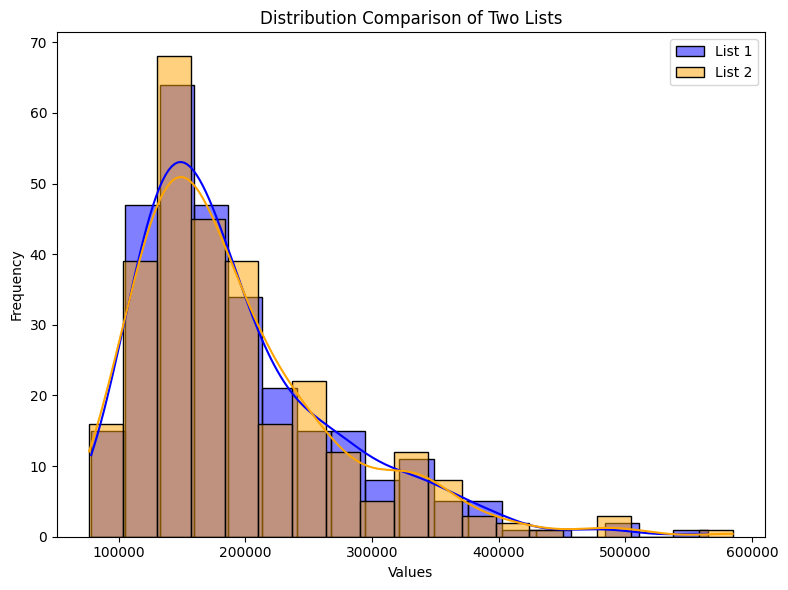

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms for each list
plt.figure(figsize=(8, 6))
sns.histplot(my_result, kde=True, label='List 1', color='blue')
sns.histplot(pca_result, kde=True, label='List 2', color='orange')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution Comparison of Two Lists')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
